In [1]:
import numpy as np
import sys, os, git
import pint
ureg = pint.UnitRegistry()

In [2]:
current_path = os.getcwd()
git_repo = git.Repo(current_path, search_parent_directories=True)
git_path = git_repo.git.rev_parse("--show-toplevel")
sys.path.append(git_path+'/pyplot-perso')
sys.path.append(git_path+"/pyplot-perso/colors")
from colorseries import colorserie1
from plttools import PltTools

In [3]:
T = 300 * ureg.kelvin
kB =  1.380649e-23 * ureg.joule/ureg.kelvin # J/K
Na = 6.022141e23/ureg.mol # mol-1
h = 6.626e-34 * ureg.joule*ureg.second # Js
mass_CO2_g_mol = 44.01 * ureg.gram/ureg.mol
mass_CO2 = mass_CO2_g_mol / Na
mass_CO2 = mass_CO2.to_base_units()
deBroglie_wavelength = np.sqrt(h**2/(2*np.pi*mass_CO2*kB*T)).to_base_units()

In [4]:
# Theory
def density_from_mu_id(mu_K, deBroglie_wavelength, kB, T):
    mu_J = (mu_K*kB).to_base_units()
    return np.exp(-mu_J/(kB*T)) / deBroglie_wavelength**3

# Directory scanner
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

def measure_isotherm(dirs, atoms = ["CO2"], data_type = "density"):
    out_data = []
    for dir in dirs:
        mean_out = 0
        for atom in atoms:
            if data_type == "density":
                out = np.loadtxt(dir+"/density_"+atom+".dat")[:,1]
            elif data_type == "pressure":
                out = np.loadtxt(dir+"/density_"+atom+".dat")[:,1]
            N_end = len(out)//50
            mean_out += np.mean(out[-N_end:])
        out_data.append(mean_out)
    out_data = np.array(out_data)
    if data_type == "density":
        out_data *= ureg.gram/ureg.centimeter**3
    elif data_type == "pressure":
        out_data *= ureg.atm
    return out_data

# Folder detector
def scan_directory(dir_lammps):
    subfolders= fast_scandir("./")
    filtered_subfolders = []
    for dir in subfolders:
        if "outputs_" in dir:
            if dir_lammps:
                if "lammps-comparison" in dir:
                    filtered_subfolders.append(dir)
            else:
                if "lammps" not in dir:
                    filtered_subfolders.append(dir) 
    chemical_potentials_K = []
    for dir in filtered_subfolders:
        mu_K = np.float32(dir.split("_")[-1][2:])
        chemical_potentials_K.append(mu_K)
    chemical_potentials_K = np.array(chemical_potentials_K)
    chemical_potentials_K = chemical_potentials_K *ureg.degree_Kelvin
    return filtered_subfolders, chemical_potentials_K

# LAMMPS data

In [34]:
lammps_dir, lammps_mu_K = scan_directory(dir_lammps = True)
lammps_rho_g_cm3 = measure_isotherm(lammps_dir, atoms = ["CO2"], data_type = "density")
lammps_p_atm = measure_isotherm(lammps_dir, atoms = ["CO2"], data_type = "pressure")

In [73]:
performance_lammps = []
out_data = []
for dir, mu in zip(lammps_dir, lammps_mu_K):
    N_GCMC_step = 2500000/100
    if mu.magnitude > 4100:
        Nattempt=10
    else:
        Nattempt=100
    log_file = open(dir+"/log.lammps")
    for line in log_file:
        pass
    h, m, s = line.split("Total wall time: ")[1][:-1].split(":")
    total_time = np.float32(h)*60+np.float32(m) # minutes
    total_GCMC_attempts = np.int32(N_GCMC_step*Nattempt)
    performance_lammps.append([mu.magnitude, total_time, total_GCMC_attempts])
performance_lammps = np.array(performance_lammps)

# GOMC data

In [76]:
gomc_dir, gomc_mu_K = scan_directory(dir_lammps = False)
gomc_rho_g_cm3 = measure_isotherm(gomc_dir, atoms = ["C", "O"], data_type = "density")
gomc_p_atm = measure_isotherm(gomc_dir, atoms = ["C", "O"], data_type = "pressure")

In [122]:
performance_gomc = []
out_data = []
for dir, mu in zip(gomc_dir, gomc_mu_K):
    log_file = open(dir+"/log.gomc")
    time_measured = False
    for line in log_file:
        if "MOVE_0" in line:
            _, STEP, DISTRY, DISACCEPT, DISACCEPT_, DISMAX, ROTATE, ROTACCEPT, ROTACCEPT, ROTMAX, REGROWTH, REGROWACCEPT, REGROWACCEPT_, TRANSFER, TRANACCEPT, TRANACCEPT = ' '.join(line.split(" ")).split()
            total_GCMC_attempts = np.int32(TRANSFER)
        if ("Simulation ends in" in line) & (time_measured is False):
            d = ' '.join(line.split(" ")).split()[5]
            h = ' '.join(line.split(" ")).split()[7]
            m = ' '.join(line.split(" ")).split()[9]
            total_time = np.float32(d)*60*24+np.float32(h)*60+np.float32(m) # minutes
            time_measured = True
    performance_gomc.append([mu.magnitude, total_time, total_GCMC_attempts])
performance_gomc = np.array(performance_gomc)

# Theory

In [24]:
mu_K = np.arange(3700, 5200)*ureg.kelvin
rho_m3 = density_from_mu_id(mu_K, deBroglie_wavelength, kB, T) # per m3
rho_g_cm3 = (rho_m3 * mass_CO2_g_mol / Na).to(ureg.gram/ureg.cm**3)

# Literature

Bulk liquid density at 300 K: approx 760 kg/m3 = 0.76 g/cm3 from Harris ˇYung J. Phys. Chem. 99 1995

# Plot

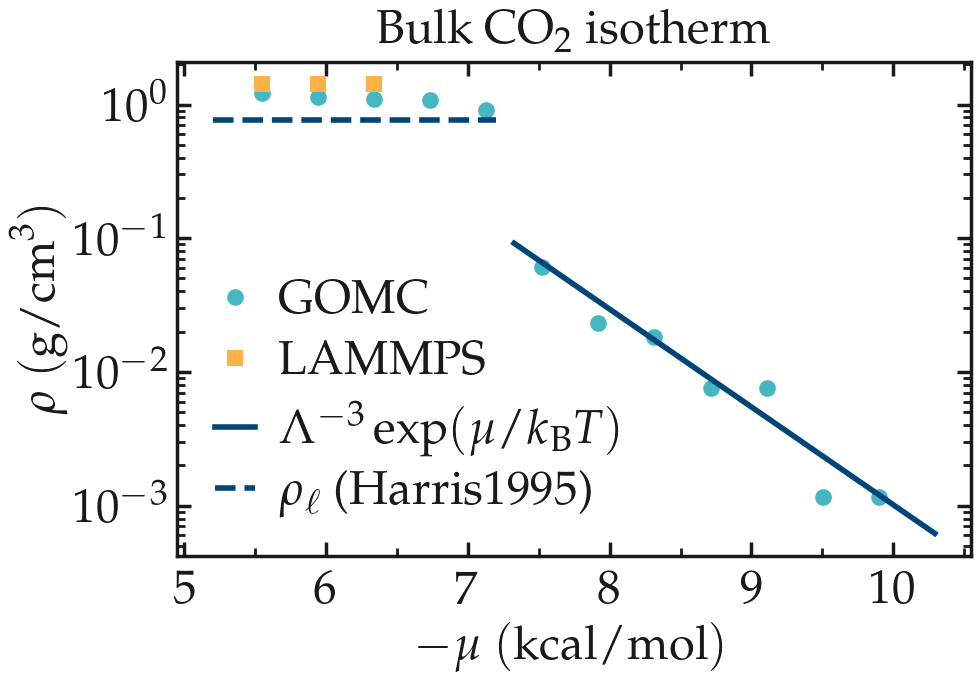

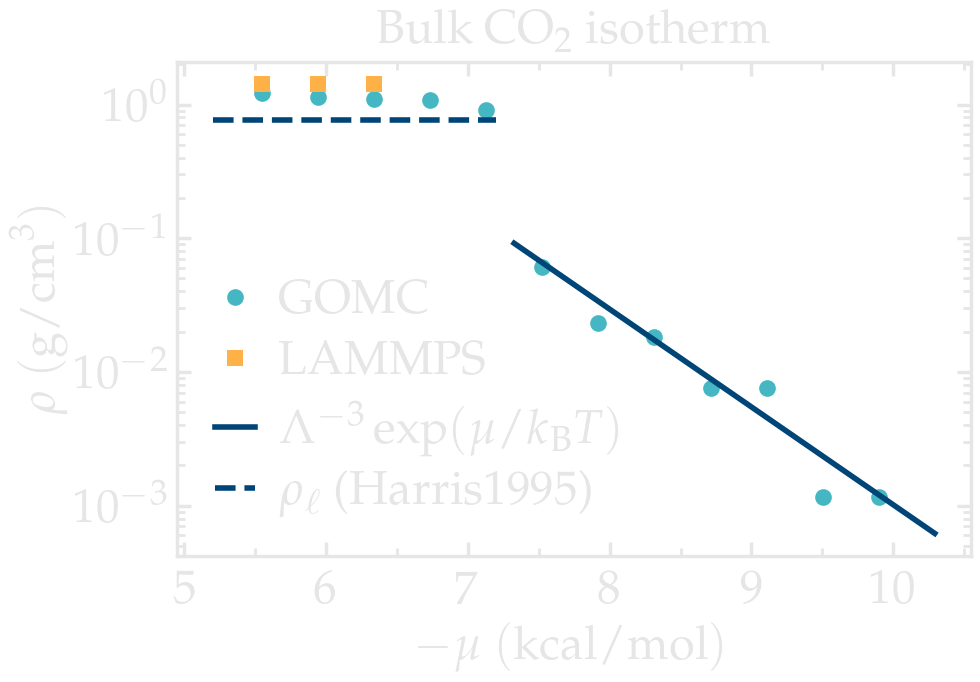

In [32]:
for dark_mode in [False, True]:

    # Initialise figure
    myplt = PltTools()
    myplt.prepare_figure(fig_size = (18,12), dark_mode = dark_mode,
                         transparency = True, n_colone = 1)
    # Panel 1
    myplt.add_panel(panel_position = [0, 0])
    myplt.add_plot(x = gomc_mu_K.magnitude*0.00198,
                   y = gomc_rho_g_cm3.magnitude,
                   type = "semilogy",
                   marker = "o", data_color = 0,
                   markersize = 12, data_label = r"$\textrm{GOMC}$")
    myplt.add_plot(x = lammps_mu_K.magnitude*0.00198,
                   y = lammps_rho_g_cm3.magnitude,
                   type = "semilogy",
                   marker = "s", data_color = 1,
                   markersize = 12, data_label = r"$\textrm{LAMMPS}$")
    myplt.add_plot(x = mu_K.magnitude*0.00198,
                   y = rho_g_cm3.magnitude,
                   type = "semilogy",
                   marker = "-", data_color = 2,
                   data_label = r"$\Lambda^{-3} \exp(\mu/k_\mathrm{B}T)$")
    myplt.add_plot(x = np.linspace(5.2,7.2),
                   y = np.linspace(5.2,7.2)*0+0.76,
                   type = "semilogy",
                   marker = "--", data_color = 2,
                   data_label = r"$\rho_\ell ~ \textrm{(Harris1995)}$")
    myplt.complete_panel(xlabel = r"$-\mu ~ (\textrm{kcal/mol})$",
                         ylabel = r"$\rho ~ (\textrm{g/cm}^3)$",
                         panel_title = r"$\textrm{Bulk CO$_2$ isotherm}$",
                         xpad = 10, legend=True)
    #myplt.set_boundaries(x_boundaries = (5, 11), y_boundaries = (0, 0.6))
    # Finish figure
    # myplt.add_subplotlabels(type_label_panel = "a")
    myplt.save_figure(filename = "CO2", saving_path = './')

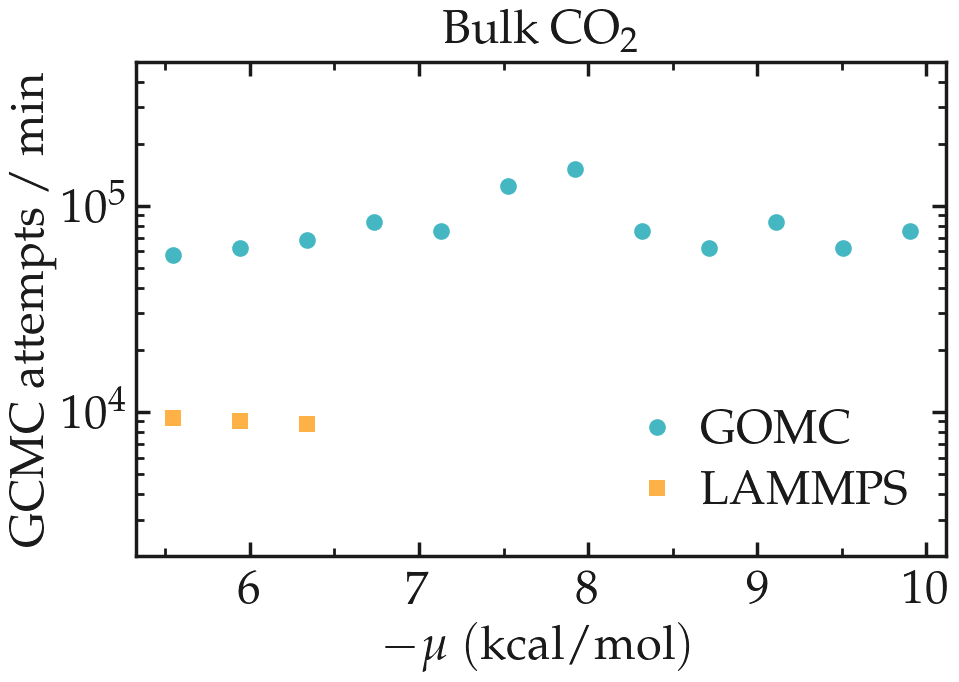

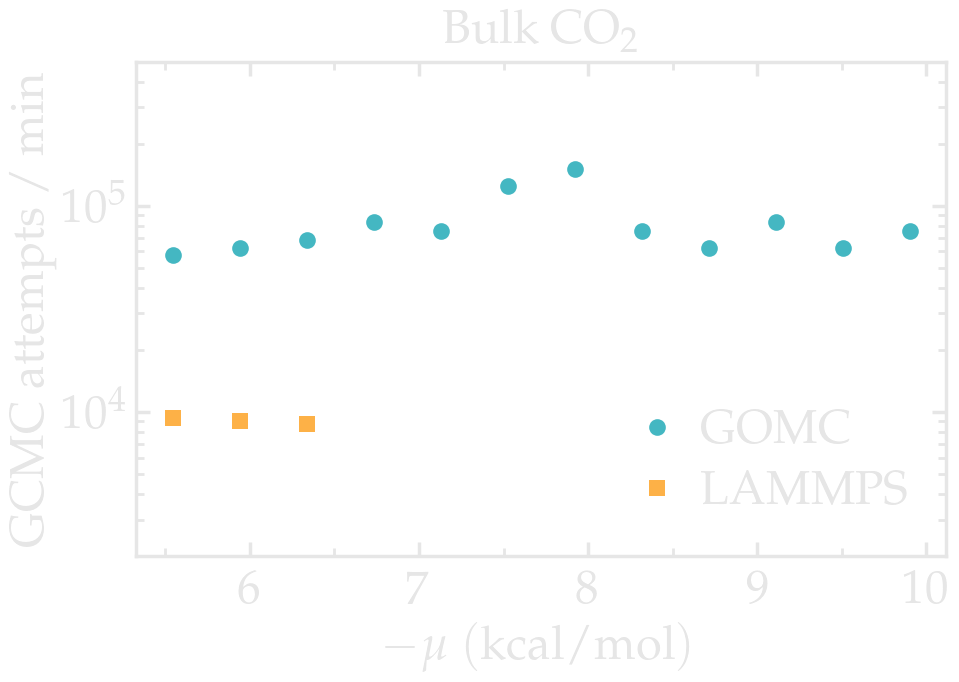

In [131]:
for dark_mode in [False, True]:

    # Initialise figure
    myplt = PltTools()
    myplt.prepare_figure(fig_size = (18,12), dark_mode = dark_mode,
                         transparency = True, n_colone = 1)
    # Panel 1
    myplt.add_panel(panel_position = [0, 0])
    myplt.add_plot(x = performance_gomc[:,0]*0.00198,
                   y = performance_gomc[:,2]/performance_gomc[:,1],
                   type = "semilogy",
                   marker = "o", data_color = 0,
                   markersize = 12, data_label = r"$\textrm{GOMC}$")
    myplt.add_plot(x = performance_lammps[:,0]*0.00198,
                   y = performance_lammps[:,2]/performance_lammps[:,1],
                   type = "semilogy",
                   marker = "s", data_color = 1,
                   markersize = 12, data_label = r"$\textrm{LAMMPS}$")
    myplt.complete_panel(xlabel = r"$-\mu ~ (\textrm{kcal/mol})$",
                         ylabel = r"$\textrm{GCMC attempts / min}$",
                         panel_title = r"$\textrm{Bulk CO$_2$}$",
                         xpad = 10, legend=True)
    myplt.set_boundaries(y_boundaries = (2000, 500000))
    # Finish figure
    # myplt.add_subplotlabels(type_label_panel = "a")
    myplt.save_figure(filename = "CO2-performance", saving_path = './')

In [121]:
performance_lammps

array([[3.20e+03, 2.85e+02, 2.50e+06],
       [2.80e+03, 2.67e+02, 2.50e+06],
       [3.00e+03, 2.77e+02, 2.50e+06]])